In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset
import torch.nn.functional as F

import torchvision.transforms as transforms
from sklearn.metrics import r2_score

from tqdm import tqdm, tqdm_notebook 

from modules import *
from utills import *

from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

#### Load data:

In [2]:
batch_size = 8
data = mri_data(transform=transforms.ToTensor())
data = torch.utils.data.DataLoader(dataset=data, batch_size=batch_size, shuffle=True, drop_last=True)

#### Build model:

 - Conditoning attributes discriminator:

In [3]:
ADAS_attr = ADASregressorFCN().cuda()
optD = torch.optim.Adam(ADAS_attr.parameters(),lr=0.001, betas=(0.,0.9))

criterion = nn.MSELoss()

Train:

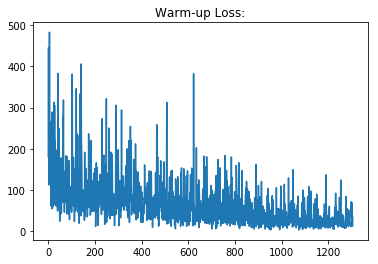

100%|██████████| 50/50 [13:42<00:00, 16.45s/it]


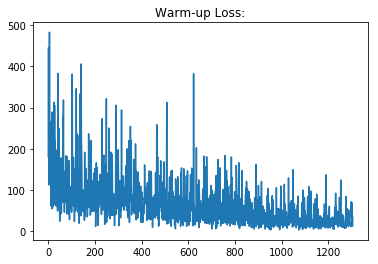

In [4]:
test_DS = list()

Dwu_losses = list()
ADAS_attr.train(True)
for epoch in tqdm(range(50)):
    for ii, (X_batch_, attr) in tqdm_notebook(enumerate(data)):
        if ii>130:
            if epoch==0:
                test_DS.append((X_batch_, attr))
            continue
            
        X_batch = Variable(X_batch_[:,1,...][:,None,...]).cuda()
        target = Variable(attr).cuda()
        
        pred = ADAS_attr(X_batch.cuda())
        
        Loss_Dwu = criterion(pred, target)
        
        Dwu_losses.append(Loss_Dwu.data.cpu().numpy()[0])
        
        ADAS_attr.zero_grad()
        Loss_Dwu.backward()
        optD.step()
        
    if epoch<1:
        continue
        
    plt.clf()
    #torch.save(ADAS_attr.state_dict(), 'ADASregressor')
    plt.plot(Dwu_losses[20:][::5])
    
    display.clear_output(wait=True)
    display.display(plt.gcf())

Test:

In [5]:
ADAS_attr.train(False)
sc = list()
preds, trues = [],[]
for X_, y_ in test_DS:
    X_batch = Variable(X_[:,1,...][:,None,...]).cuda()
    
    pred = ADAS_attr(X_batch)
    pred = pred.view(pred.size(0), -1)
    pred = pred.data.cpu().numpy().ravel()
    
    true = y_.numpy().ravel()
    
    sc.append(r2_score(y_true=true, y_pred=pred))
    
print('Regressor score:', np.mean(sc))

Classifier score: 0.845617502369


- Set U-Net type generator & adversarial discriminator:

In [3]:
g = unetGen(cond_dim=1).cuda()
adversarial_disc = ADVdiscriminator().cuda()

attr_disc = ADASregressorFCN().cuda()
attr_disc.load_state_dict(torch.load('ADASregressorFCN'))
attr_disc.train(False);

In [4]:
optG = torch.optim.Adam(g.parameters(),lr=0.001, betas=(0.,0.9))
optD = torch.optim.Adam(adversarial_disc.parameters(),lr=0.001, betas=(0.,0.9))

criterion = nn.MSELoss()

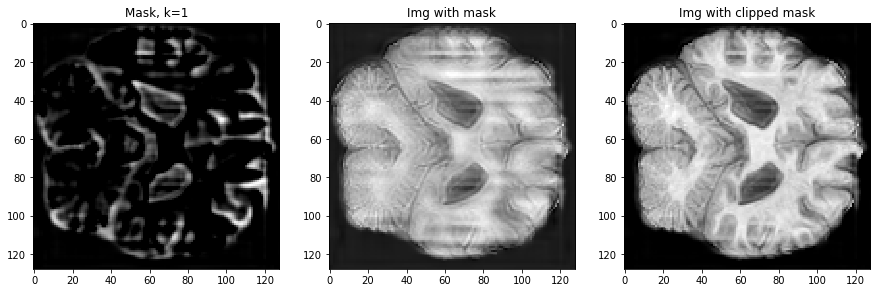

100%|██████████| 50/50 [6:33:48<00:00, 472.57s/it]


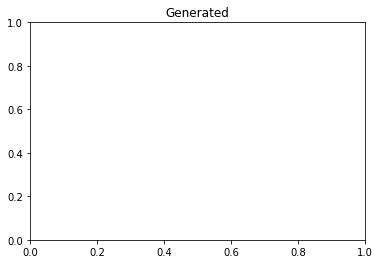

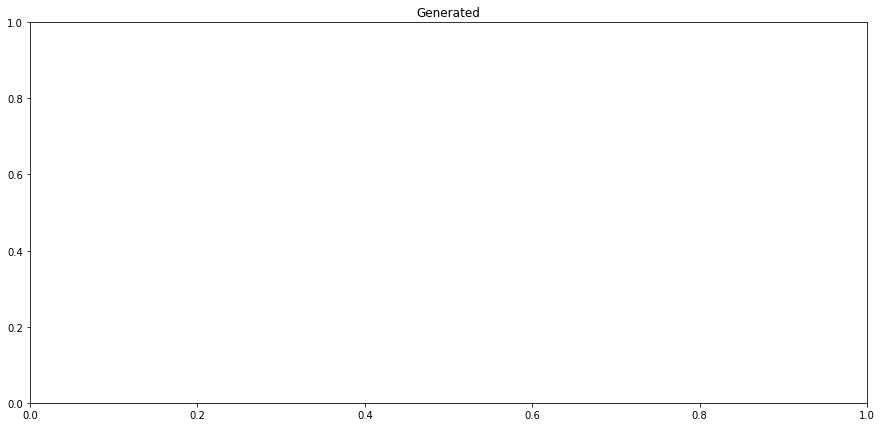

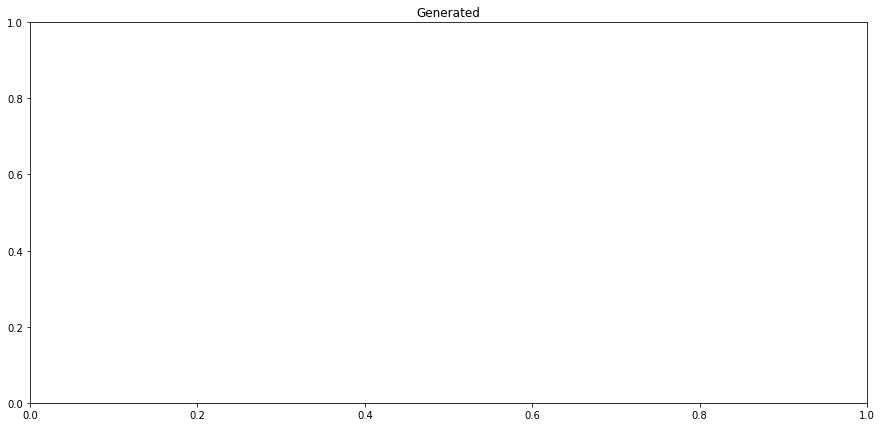

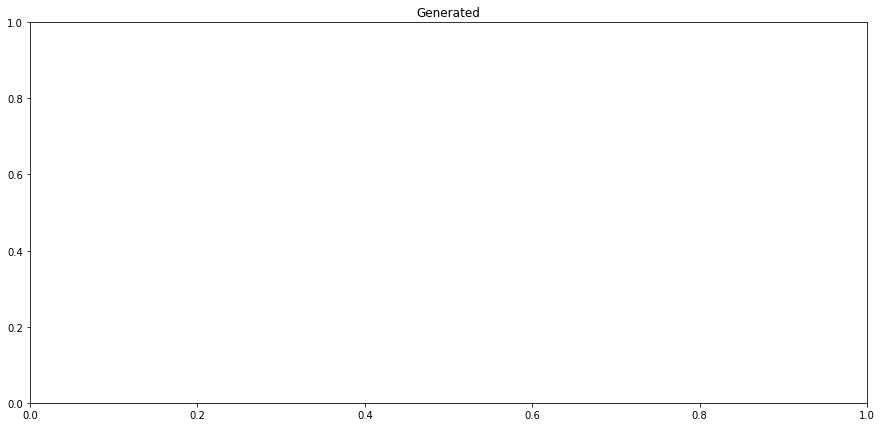

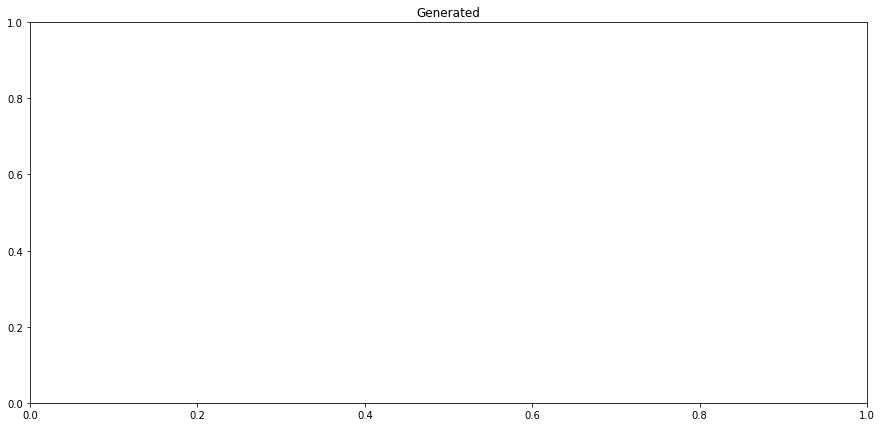

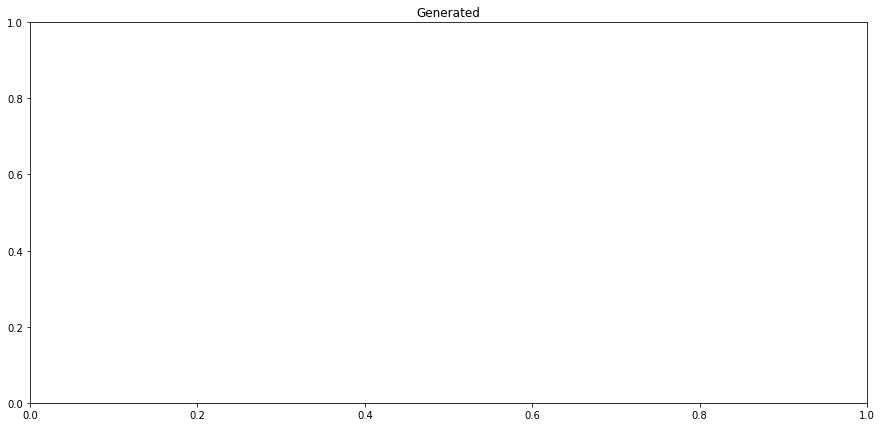

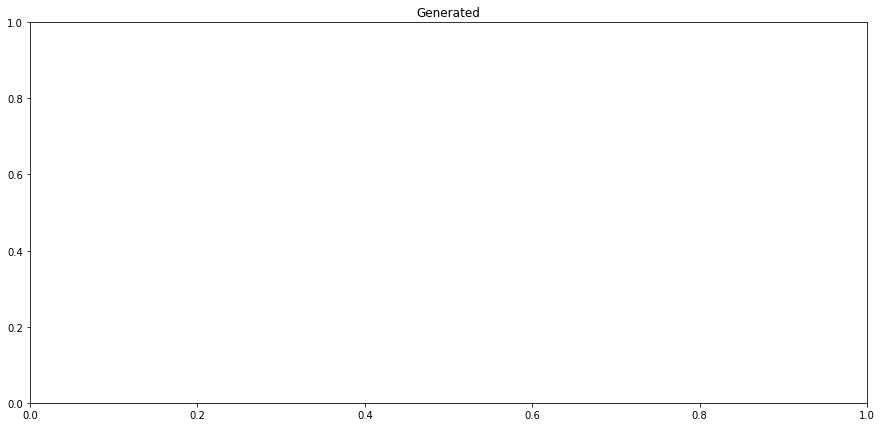

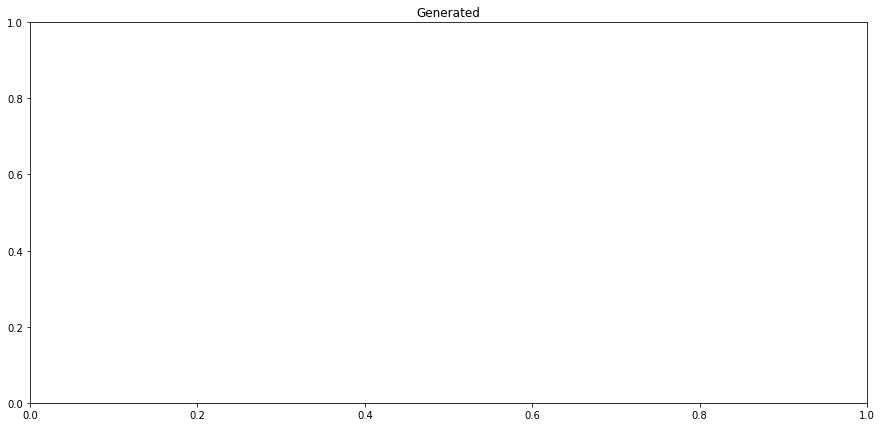

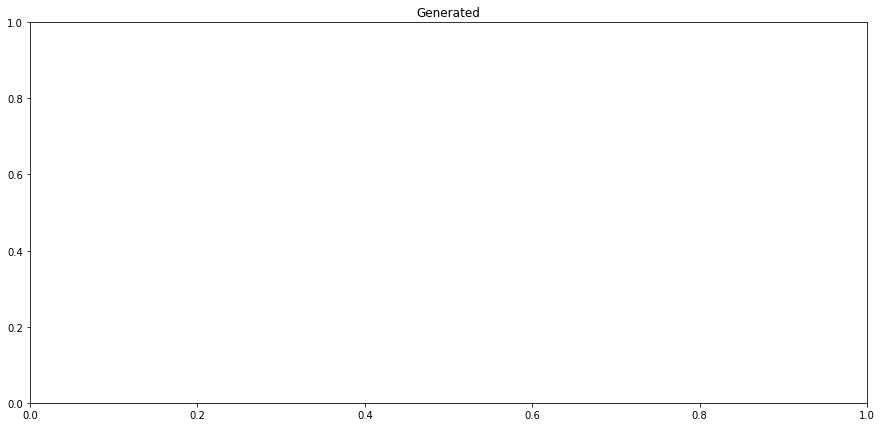

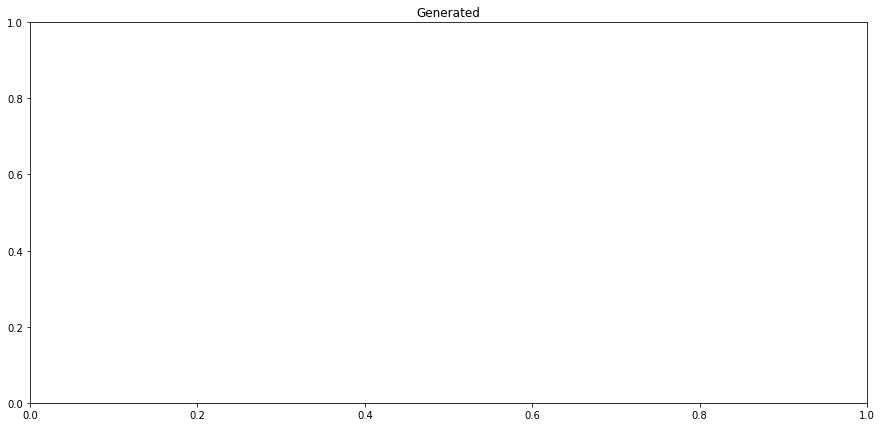

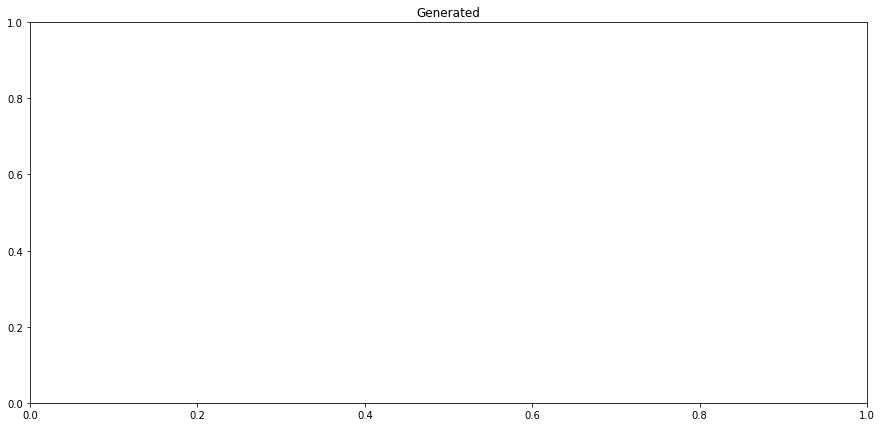

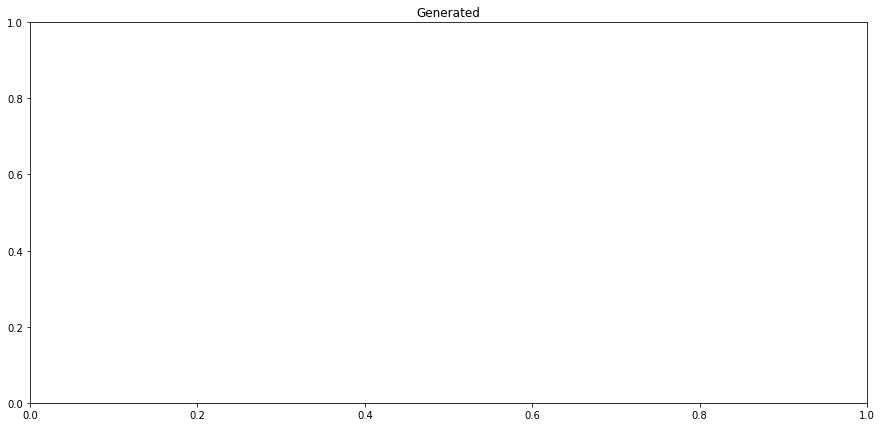

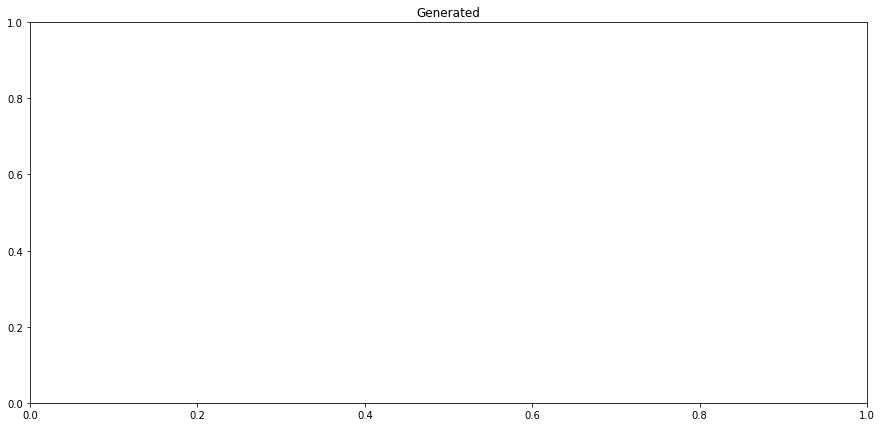

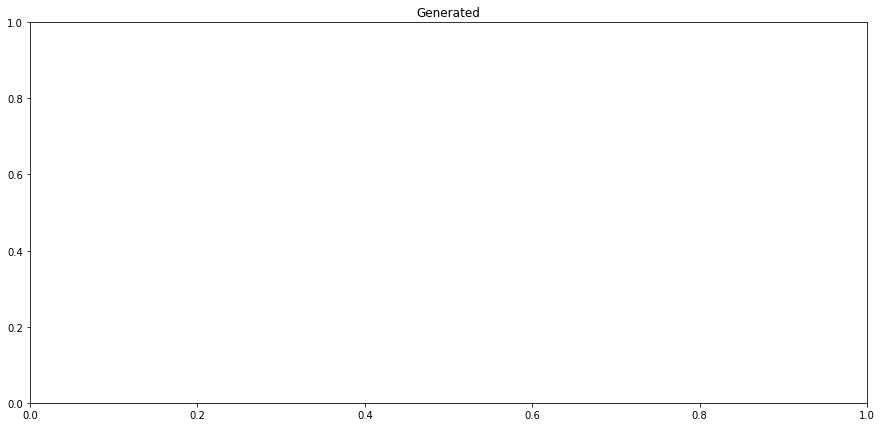

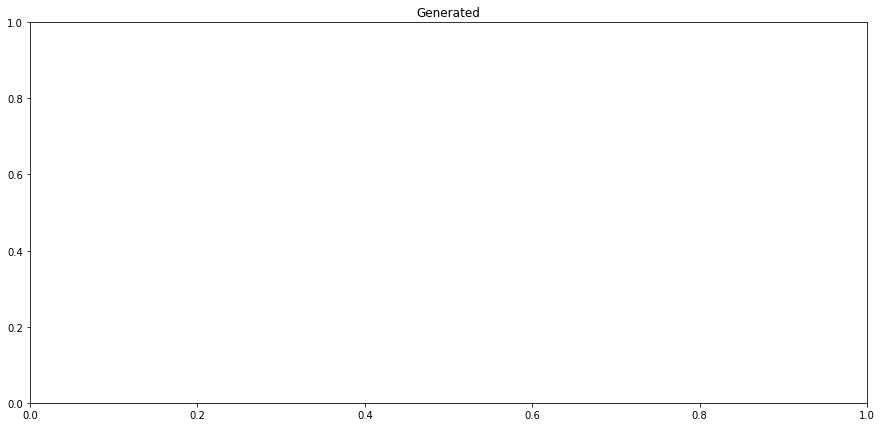

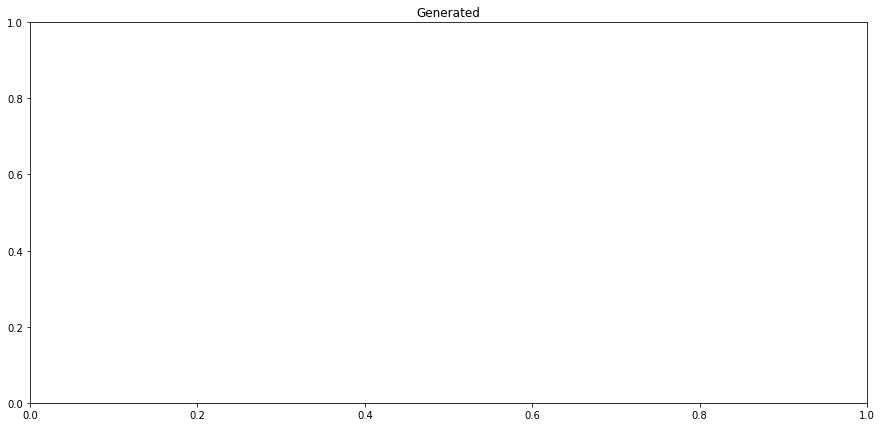

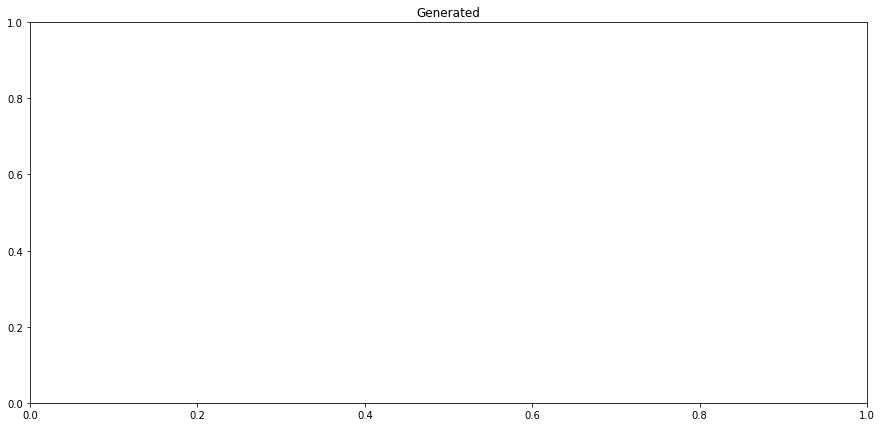

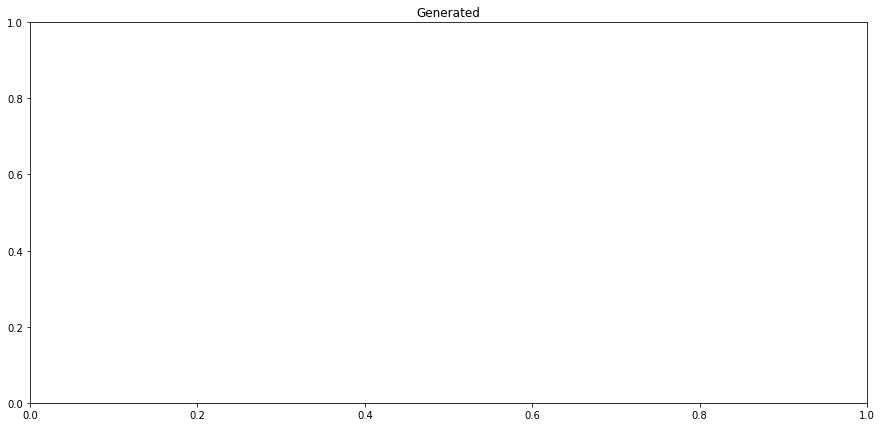

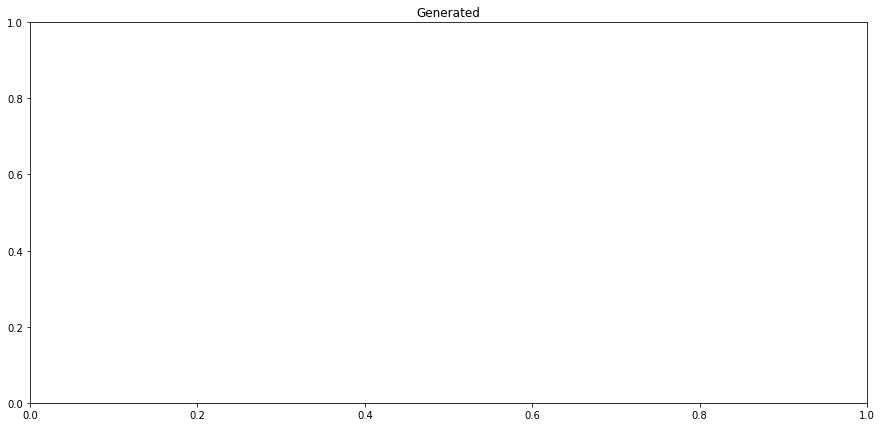

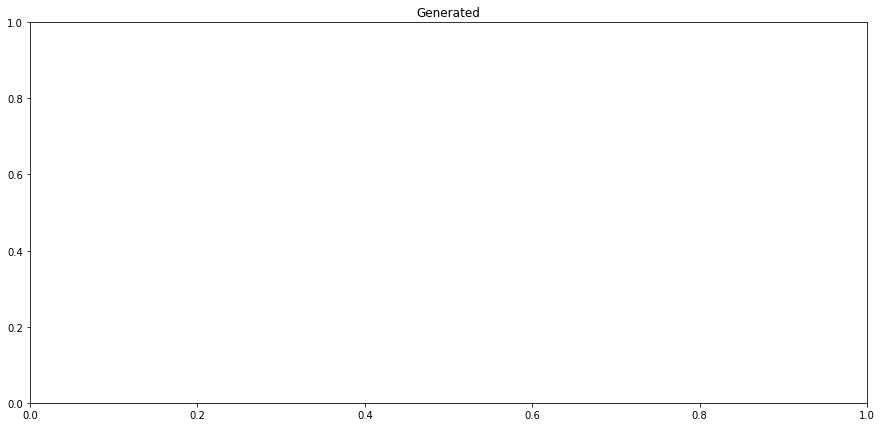

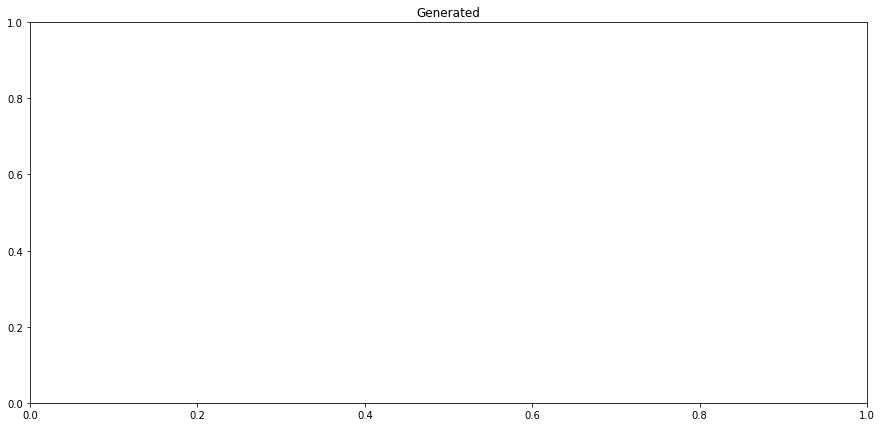

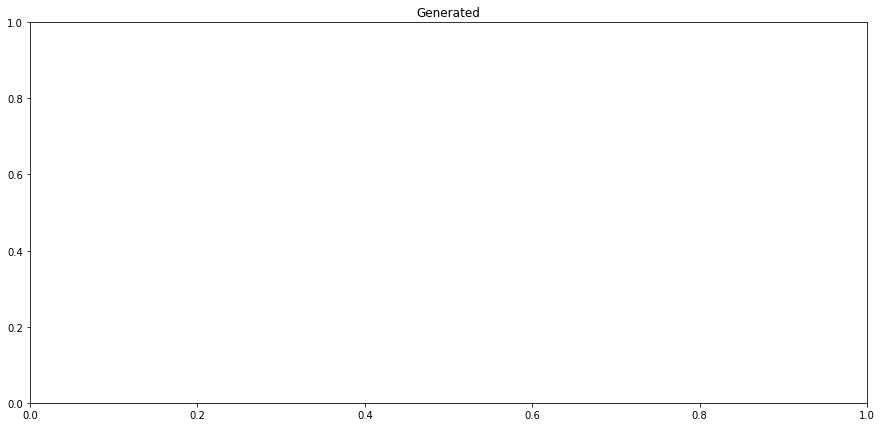

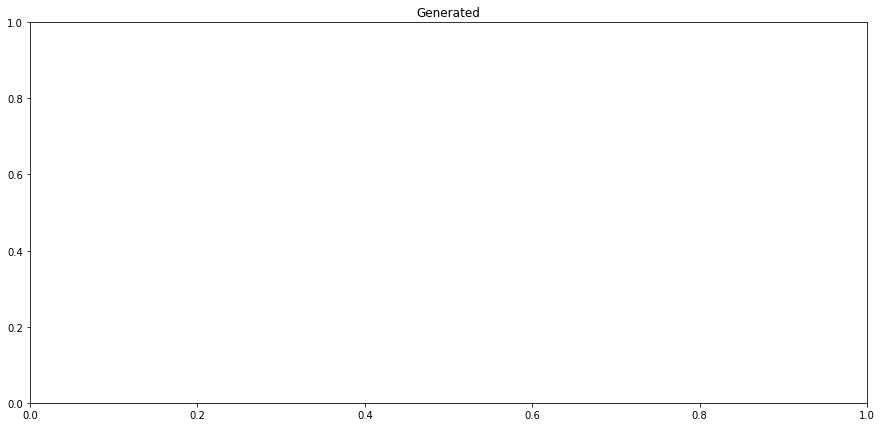

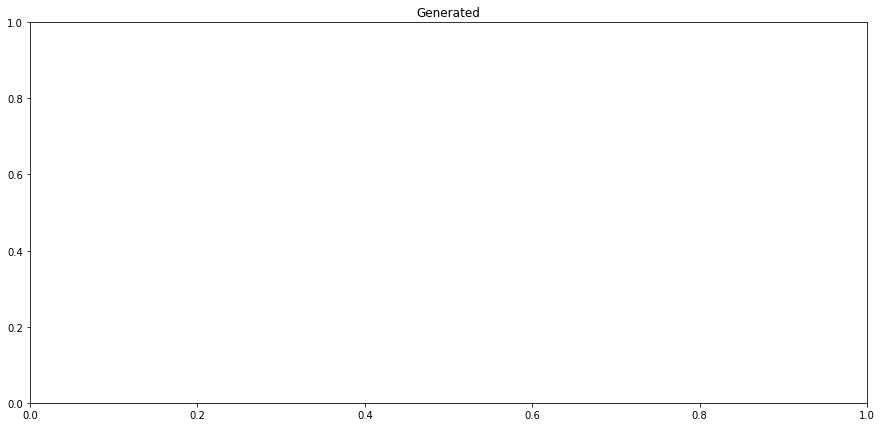

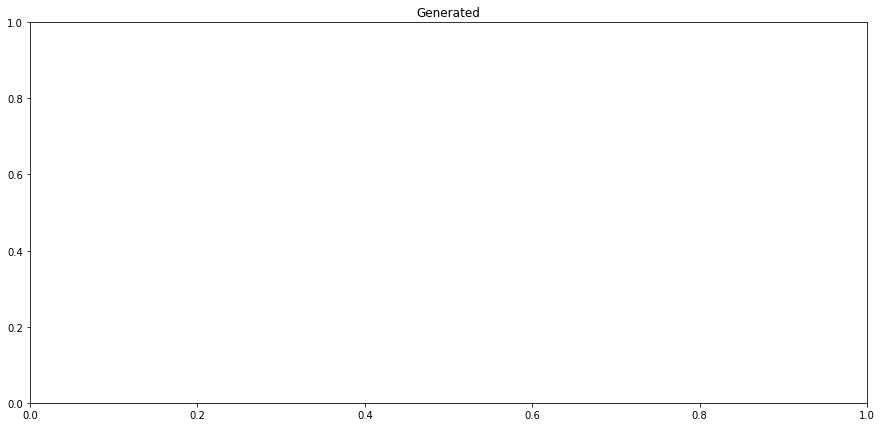

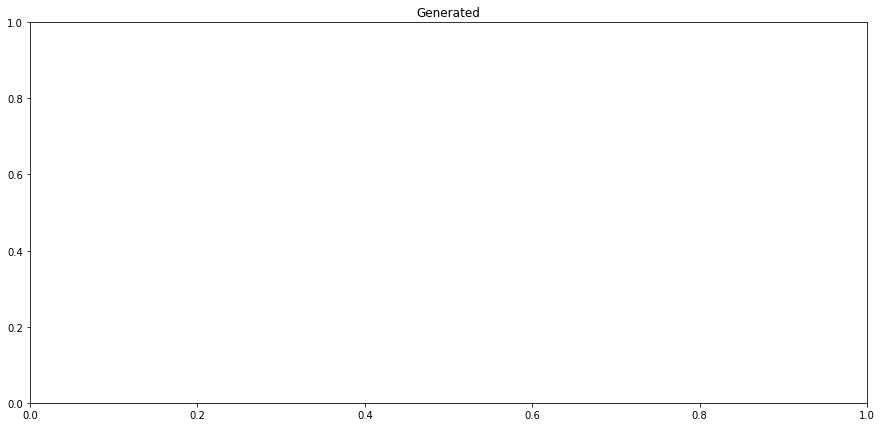

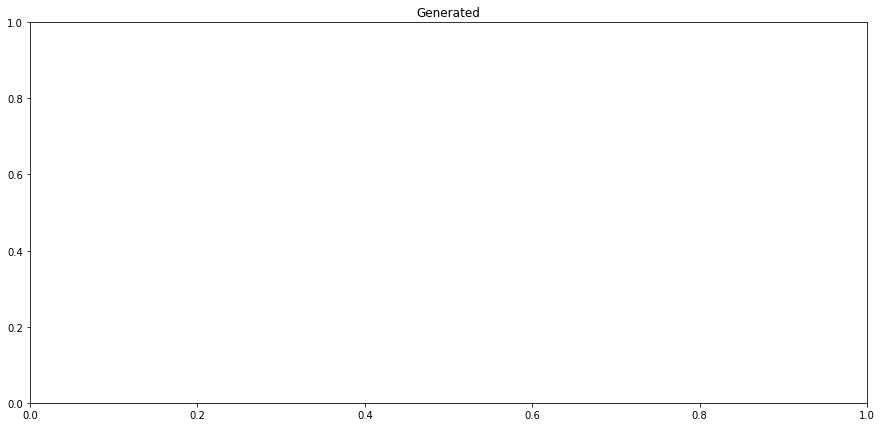

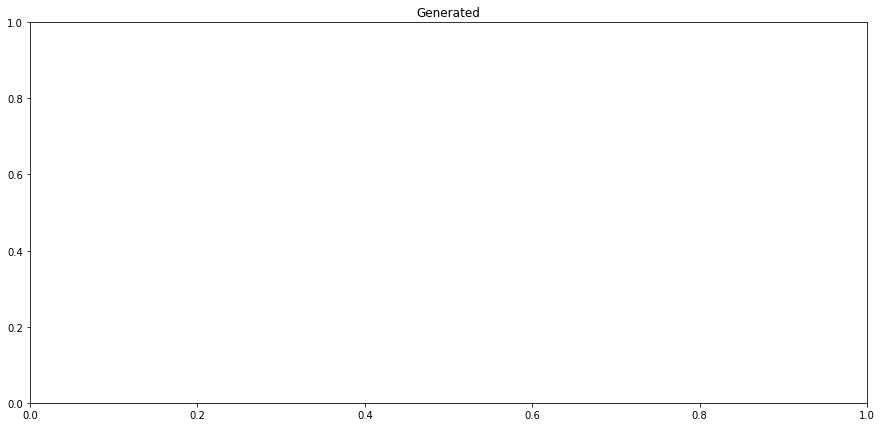

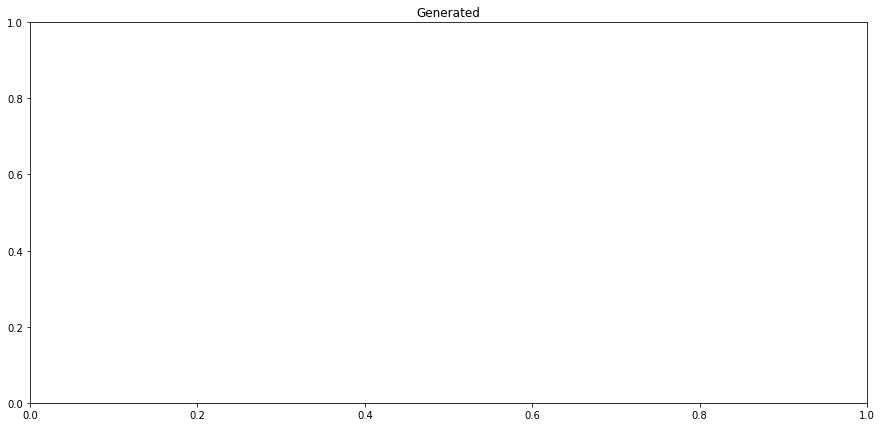

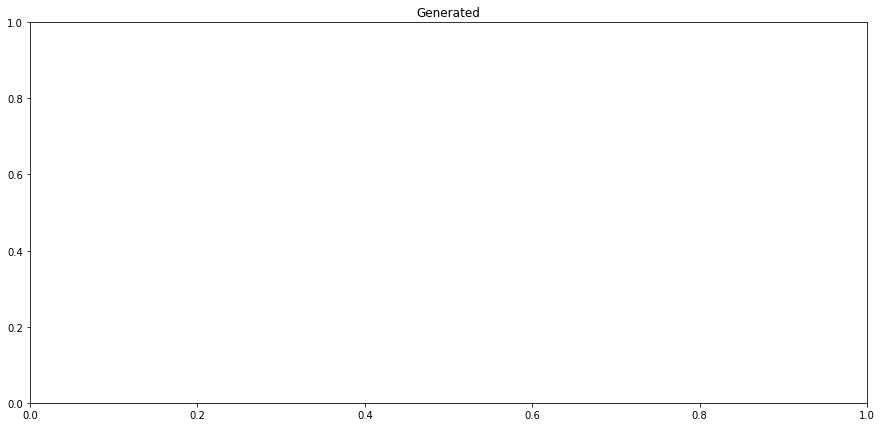

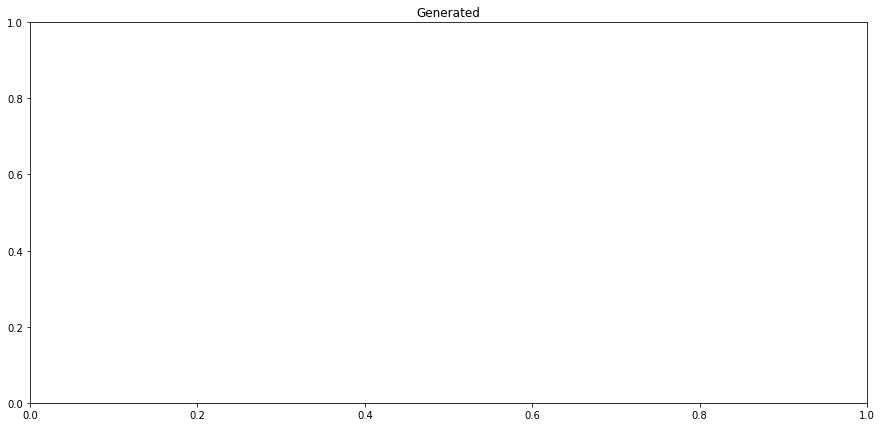

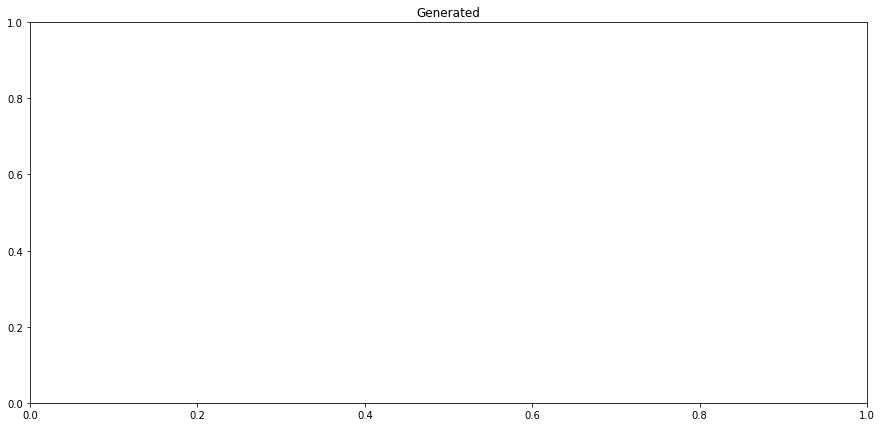

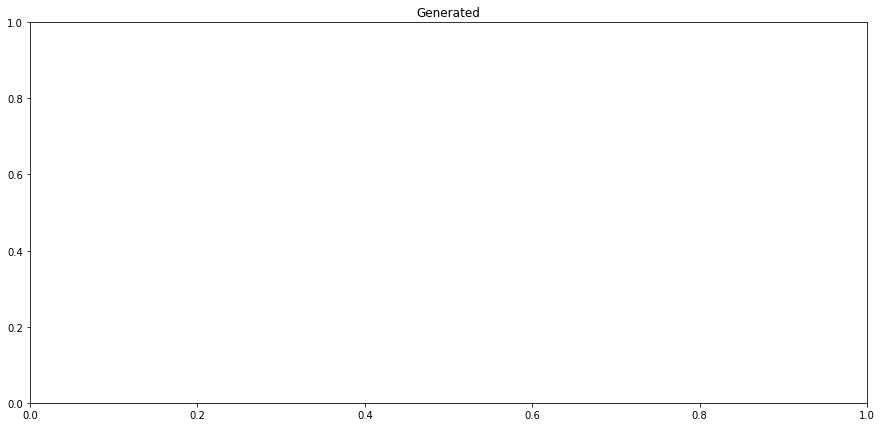

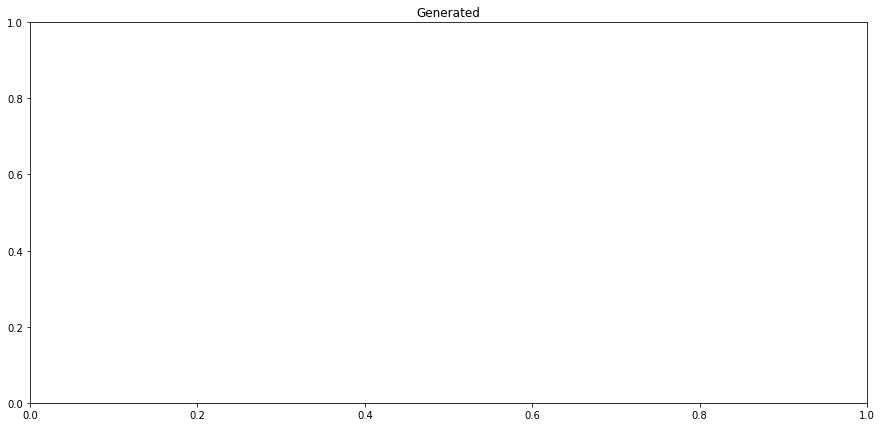

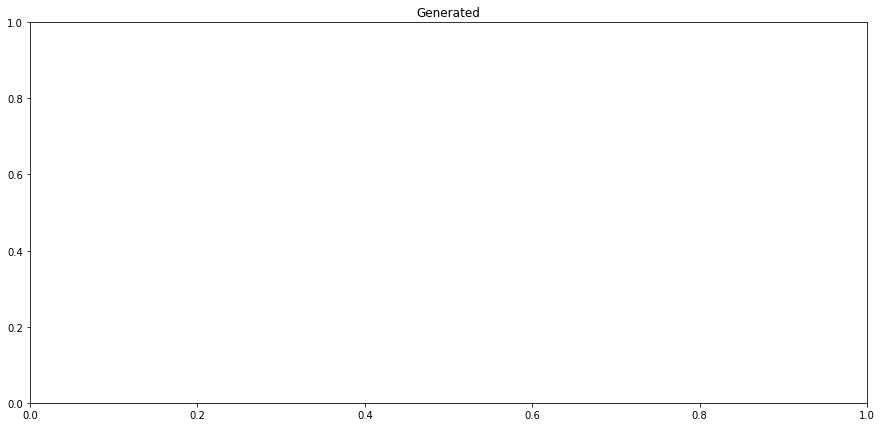

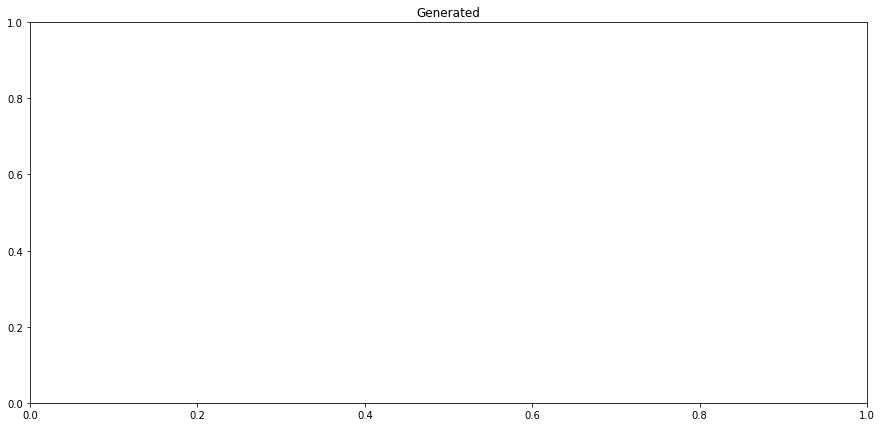

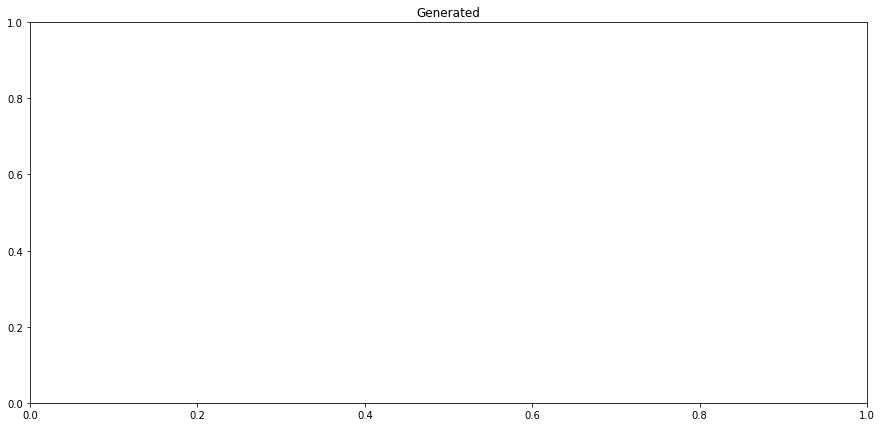

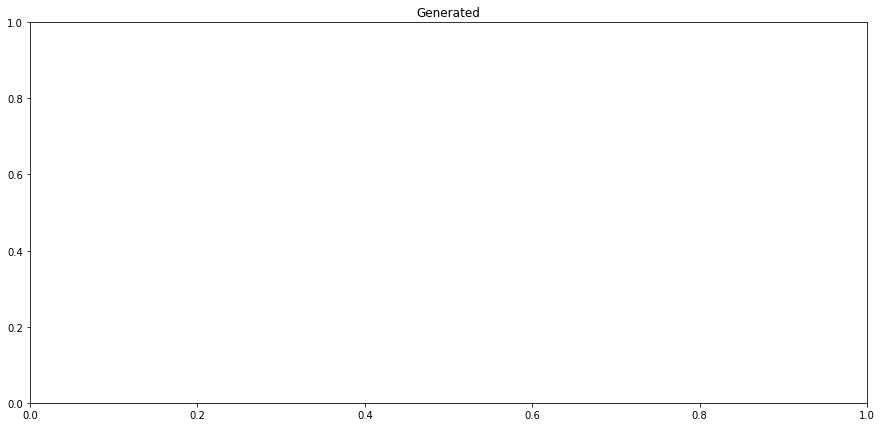

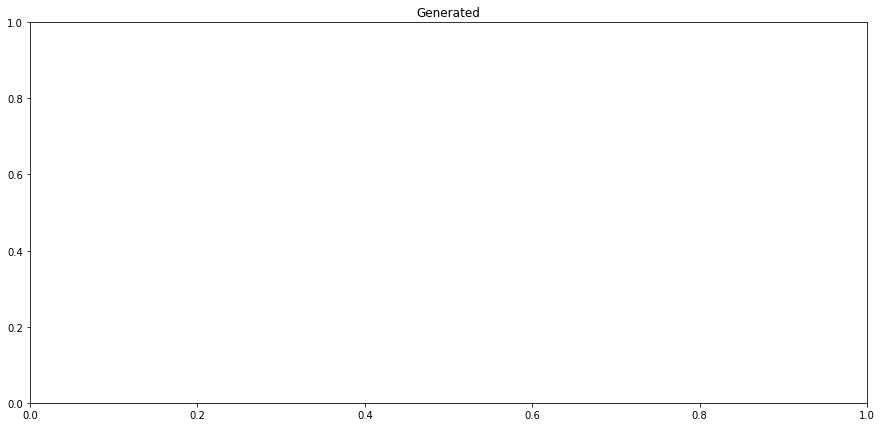

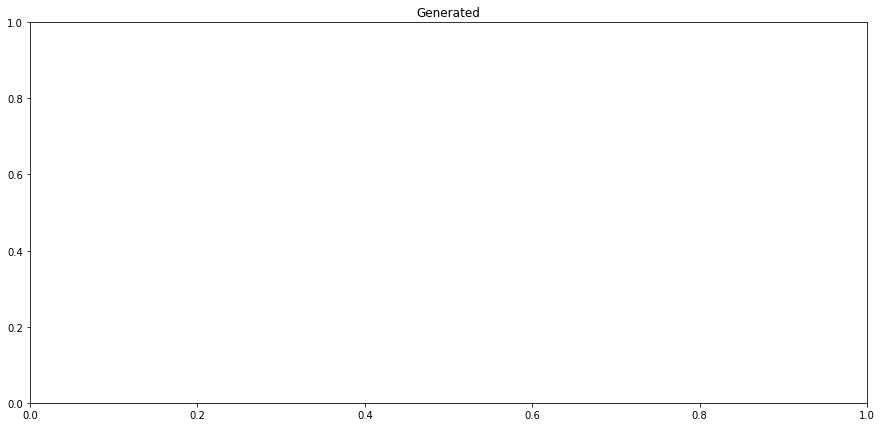

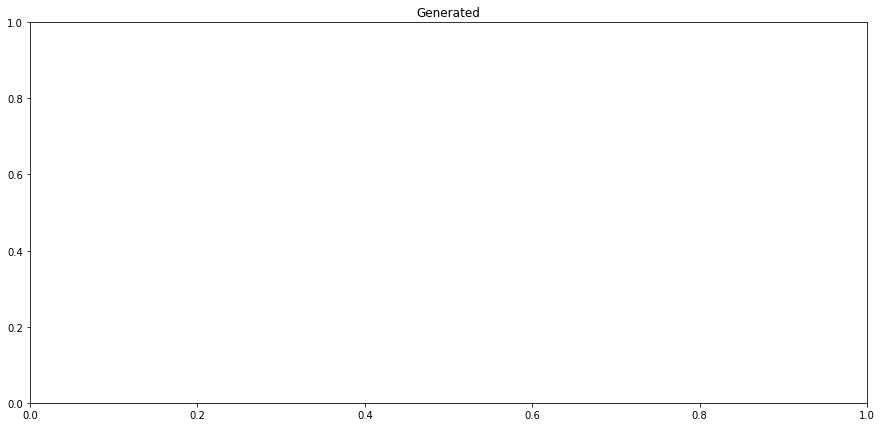

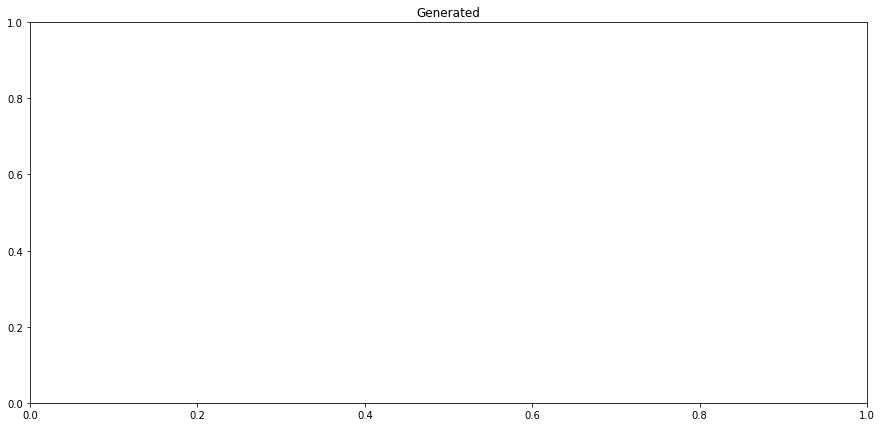

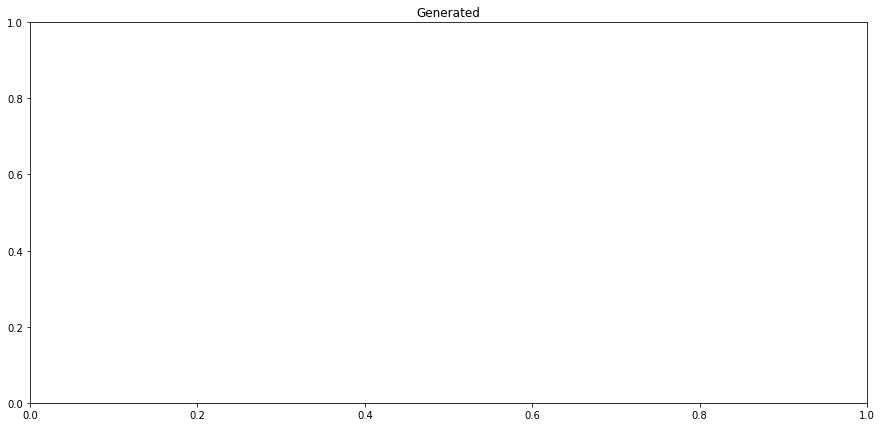

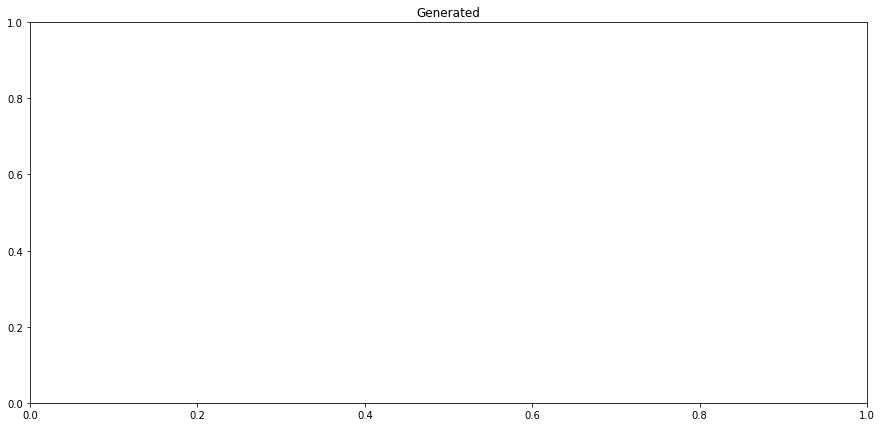

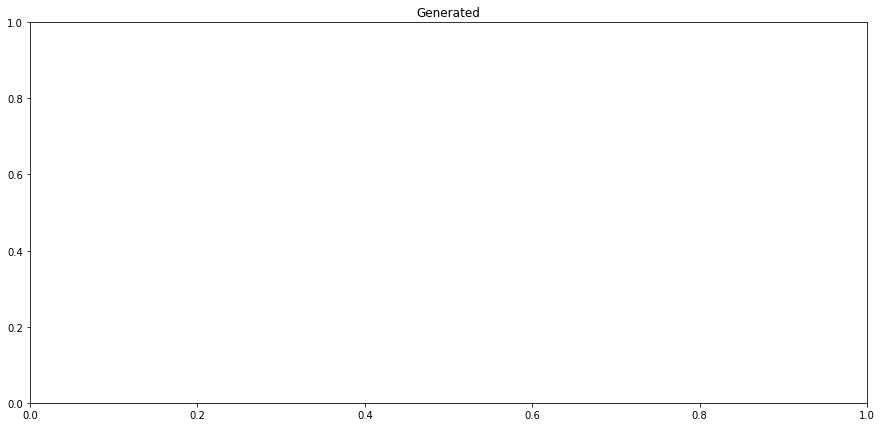

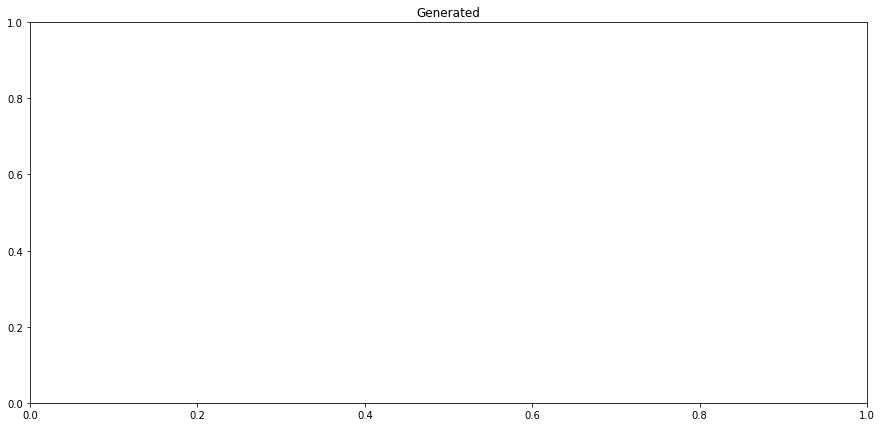

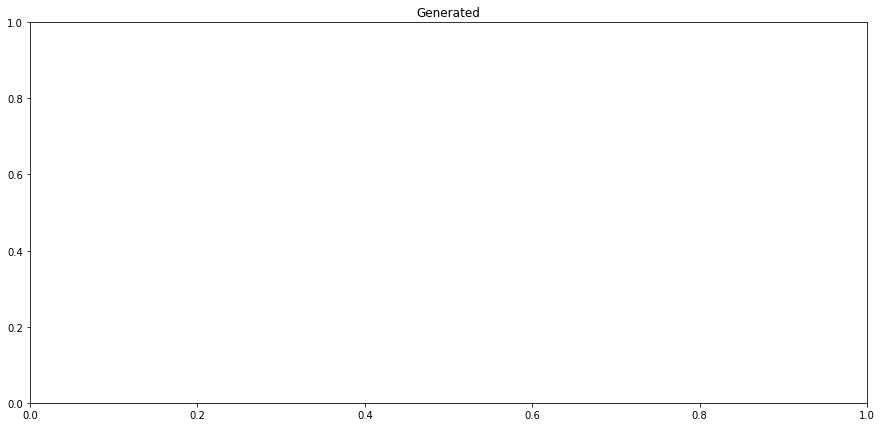

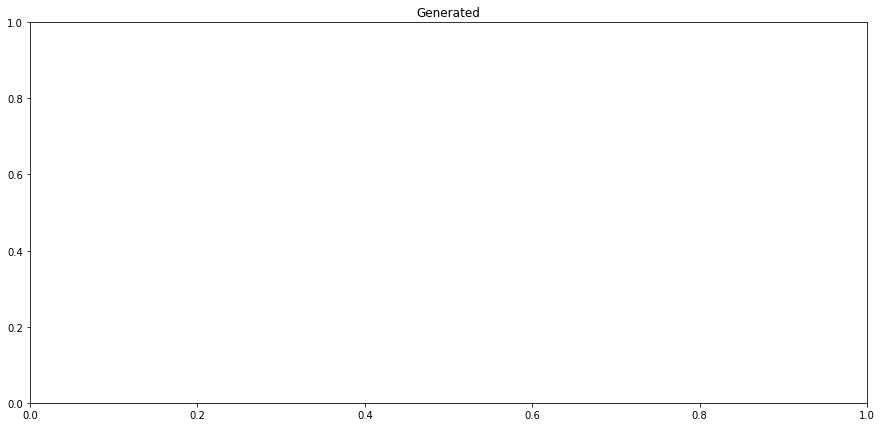

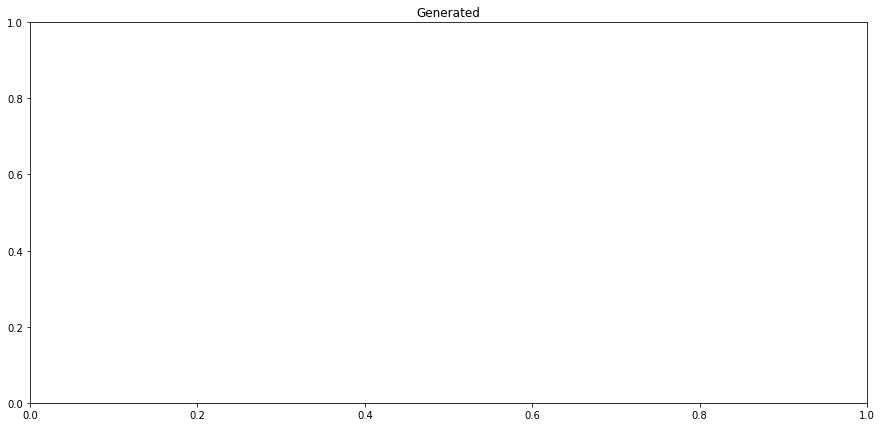

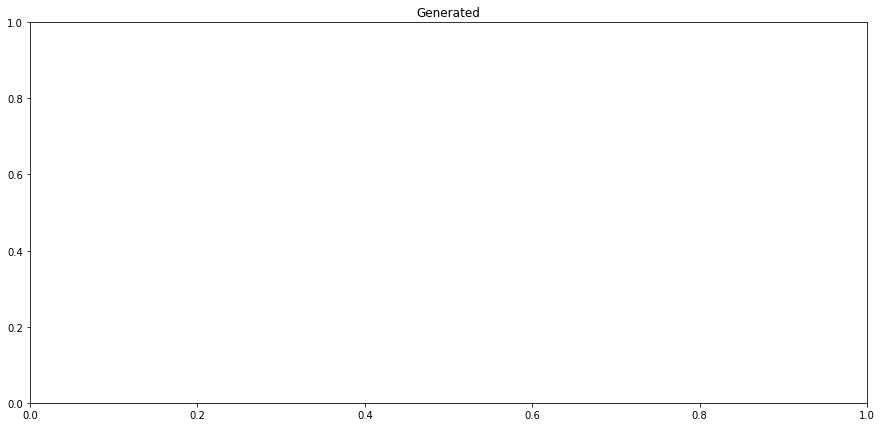

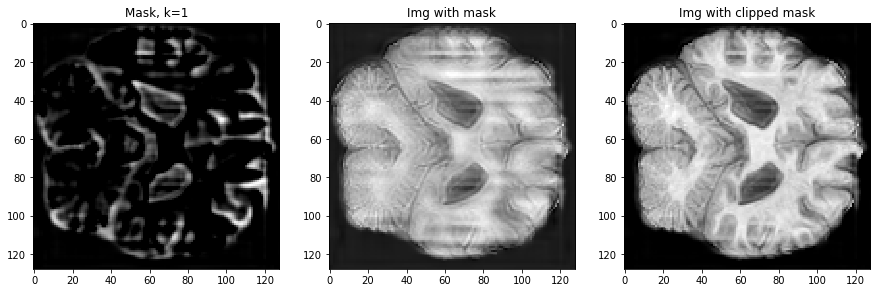

In [5]:
G_imgs, D_losses, G_losses = list(), list(), list()
Sfs, Srs, MSE_losses, L1_losses, GPs = list(), list(), list(), list(), list()
k=1

for epoch in tqdm(range(50)):
    g.train(True)
    
    for X_batch_, attr in tqdm_notebook(data):
        
        for _ in range(k): #train adversarial_disc
            
            X_batch = Variable(X_batch_[:,1,...][:,None,...]).cuda()
            y = Variable(attr[...,None, None])
            
            y_hat = y[torch.randperm(y.size(0)),...]
            y_hat_replicated = y_hat.repeat(1,1,X_batch.size(2),X_batch.size(3)).cuda()
            
            generated_mask = g(X_batch, y_hat_replicated)
            x_hat = torch.add(X_batch, generated_mask)
            
            #train ADV discriminator with real images
            Sr = adversarial_disc(X_batch)
            
            #train ADV discriminator with fake images
            Sf = adversarial_disc(x_hat)
            
            #calculate GP
            GP = torch.autograd.grad(outputs=Sf, inputs=x_hat, grad_outputs=torch.ones_like(Sf),
                                 create_graph=True, retain_graph=True)[0] #we take gradient 
                                                                          #with respect to whole masked image
            #update D
            Sfs.append(Sf.mean().data.cpu().numpy()[0])
            Srs.append(Sr.mean().data.cpu().numpy()[0])
            GPs.append(10*torch.pow(torch.norm(GP,2)-1,2).cpu().data.numpy()[0])
            
            Loss_D = Sr.mean() - Sf.mean() + 10*torch.pow(torch.norm(GP,2)-1,2)
            adversarial_disc.zero_grad()
            D_losses.append(Loss_D.data.cpu().numpy()[0])
            
            Loss_D.backward()
            optD.step()
            
        #train generator
        generated_mask = g(X_batch, y_hat_replicated)
        x_hat = torch.add(X_batch, generated_mask)
        predicted_attr4x_hat = attr_disc(x_hat)
        
        MSE_attr_loss = criterion(predicted_attr4x_hat, y_hat.cuda())
        L1_loss = torch.norm(x_hat, 1)
        
        Loss_G = adversarial_disc(x_hat).mean() + MSE_attr_loss + torch.log(L1_loss)
        
        G_losses.append(Loss_G.data.cpu().numpy()[0])
        MSE_losses.append(MSE_attr_loss.data.cpu().numpy()[0])
        L1_losses.append(L1_loss.data.cpu().numpy()[0])
        
        #update G
        g.zero_grad()
        Loss_G.backward()
        optG.step()
        
    #test generator
    g.train(False)
    plt.clf()
    plt.title('Generated')
        
    generated = g(X_batch[0,0,...][None,None,...], y_hat_replicated[0,...][None,...])
    masked_img = (X_batch[0,0,...][None,None,...] + generated)[0,0,...].cpu().data.numpy()
    generated = generated[0,0,...].cpu().data.numpy()
    masked_img_clap = np.clip(generated.copy(),0,1) + X_batch[0,0,...][None,None,...].cpu().data.numpy()
    
    G_imgs.append(np.abs(np.clip(generated, 0, 1)))
    
    #imsave(str(epoch)+'.png',arr=img_as_float(G_imgs[-1]))
    torch.save(g.state_dict(), 'generator')
    
    fig, ax = plt.subplots(1,3, figsize=(15,7))
    ax[0].imshow(G_imgs[-1], cmap='gray')
    ax[0].set_title('Mask, k='+str(k))
    
    ax[1].imshow(masked_img, cmap='gray')
    ax[1].set_title('Img with mask')
    
    ax[2].imshow(masked_img_clap[0,0,...], cmap='gray')
    ax[2].set_title('Img with clipped mask')
    
    display.clear_output(wait=True)
    display.display(plt.gcf())